In [ ]:
# -*- coding: utf-8 -*-
# Name: Kishan Kumar Sachdeva
# Email: ksachdev@ucsd.edu
# PID: A53104678
from pyspark import SparkContext
sc = SparkContext()

In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

### Cover Type

Classify geographical locations according to their predicted tree cover:

* **URL:** http://archive.ics.uci.edu/ml/datasets/Covertype
* **Abstract:** Forest CoverType dataset
* **Data Set Description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

In [ ]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
# print 'Tree Cover Types:'
# CoverTypes

In [ ]:
# #creating a directory called covtype, download and decompress covtype.data.gz into it

# from os.path import exists
# if not exists('covtype'):
#     print "creating directory covtype"
#     !mkdir covtype
# %cd covtype
# if not exists('covtype.data'):
#     if not exists('covtype.data.gz'):
#         print 'downloading covtype.data.gz'
#         !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
#     print 'decompressing covtype.data.gz'
#     !gunzip -f covtype.data.gz
# !ls -l
# %cd ..

In [ ]:
# # Define the feature names
# cols_txt="""
# Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
# Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
# Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
# Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
# Soil_Type (40 binary columns), Cover_Type
# """

In [ ]:
# # Break up features that are made out of several binary features.
# from string import split,strip
# cols=[strip(a) for a in split(cols_txt,',')]
# colDict={a:[a] for a in cols}
# colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
# colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
# Columns=[]
# for item in cols:
#     Columns=Columns+colDict[item]

In [ ]:
# Have a look at the first two lines of the data file
# !head -2 covtype/covtype.data

In [2]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='covtype/covtype.data'
inputRDD=sc.textFile(path)
#inputRDD.first()

In [ ]:
# # Transform the text RDD into an RDD of LabeledPoints
# Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
#      .map(lambda x:LabeledPoint(x[54],x[:54]))
# # Data.first()
        

In [ ]:
# # count the number of examples of each type
# total=Data.cache().count()
# print 'total data size=',total
# counts=Data.map(lambda point:(point.label,1)).countByKey()
# print '              type (label):   percent of total'
# print '---------------------------------------------------------'
# print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a],a,100.0*counts[a]/float(total)) for a in range(1,8)])

### Making the problem binary

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovTYpe` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefor transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

In [3]:
Label=2.0
Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
    .map(lambda V:LabeledPoint(V[54]==Label,V[:54]))

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 10

In [4]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3],seed=255)

#print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

In [5]:
# counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
# counts.sort(key=lambda x:x[1],reverse=True)
# #counts

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) from the mllib documentation

* [pyspark.mllib.tree.GradientBoostedTrees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [6]:
print 'Gradient Boosted Trees'
from time import time
errors={}
for depth in [1,3,6,10,15]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,
                                             categoricalFeaturesInfo={}, numIterations=10,
                                               maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
#print errors
B10 = errors

Gradient Boosted Trees
1 {'test': 0.2748812420345267, 'train': 0.27405546476743337} 117 seconds
3 {'test': 0.24852276677094196, 'train': 0.2459816093075441} 55 seconds
6 {'test': 0.21330089213300893, 'train': 0.2023220078538501} 65 seconds
10 {'test': 0.16614529023288147, 'train': 0.12371033439839996} 99 seconds
15 {'test': 0.13532614992469008, 'train': 0.03412278348252396} 236 seconds


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


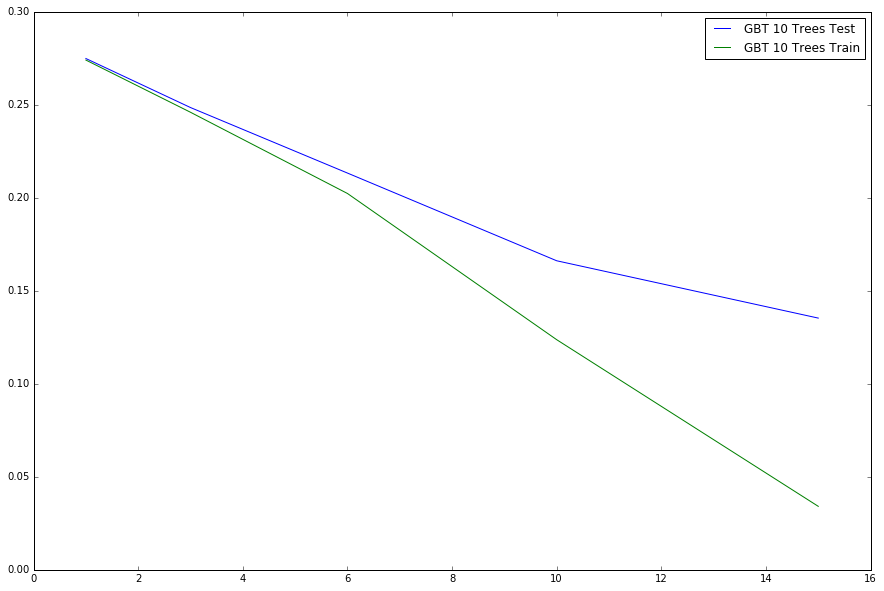

In [7]:
B10_keys=[]
B10_train=[]
B10_test=[]
for pt in sorted(B10.keys()):
    B10_keys.append(pt)
    B10_test.append(B10[pt]['test'])
    B10_train.append(B10[pt]['train'])
    
%pylab inline
figure(figsize=(15,10))
plot(B10_keys,B10_test,label='GBT 10 Trees Test')
plot(B10_keys,B10_train,label='GBT 10 Trees Train')

pylab.legend()

### Random Forests

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

In [8]:
from pyspark.mllib.tree import RandomForest
#from time import time
print 'Random Forest'
errors={}
for depth in [1,3,6,10,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=4, categoricalFeaturesInfo={},
                                     numTrees=8, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=depth, maxBins=32)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
RF_10trees = errors
#print errors

Random Forest
1 {'test': 0.3286988761441316, 'train': 0.3317397985316715} 11 seconds
3 {'test': 0.2871046228710462, 'train': 0.2841044903534233} 10 seconds
6 {'test': 0.2543158382574441, 'train': 0.25203053733017877} 15 seconds
10 {'test': 0.23861661452902327, 'train': 0.23024951828093368} 17 seconds
20 {'test': 0.19505271695052717, 'train': 0.158711188077758} 32 seconds


Populating the interactive namespace from numpy and matplotlib


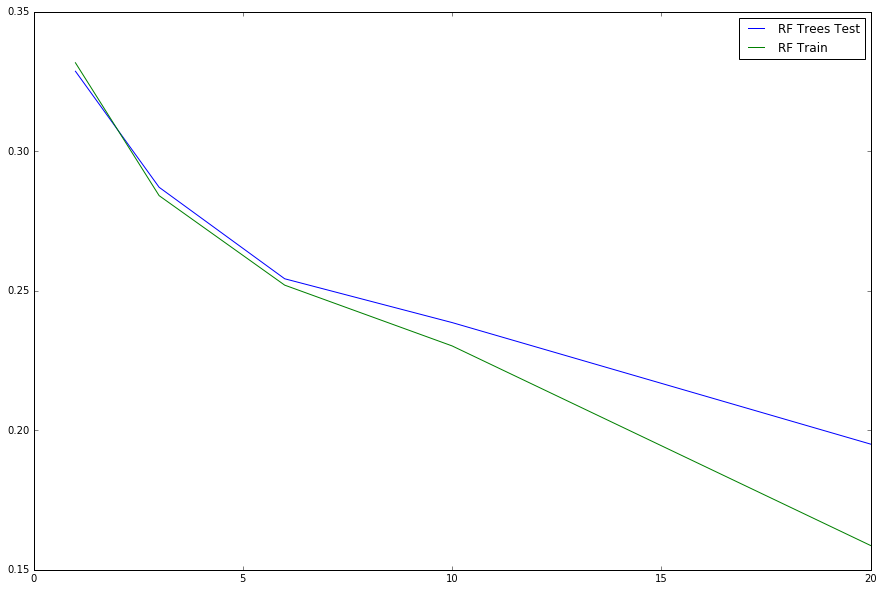

In [9]:
RF10_keys=[]
RF10_train=[]
RF10_test=[]
for pt in sorted(RF_10trees.keys()):
    RF10_keys.append(pt)
    RF10_test.append(RF_10trees[pt]['test'])
    RF10_train.append(RF_10trees[pt]['train'])

    
%pylab inline
figure(figsize=(15,10))
plot(RF10_keys,RF10_test,label='RF Trees Test')
plot(RF10_keys,RF10_train,label='RF Train')

pylab.legend()

### Now plot B10 and RF_10trees performance curves in the same graph

Populating the interactive namespace from numpy and matplotlib


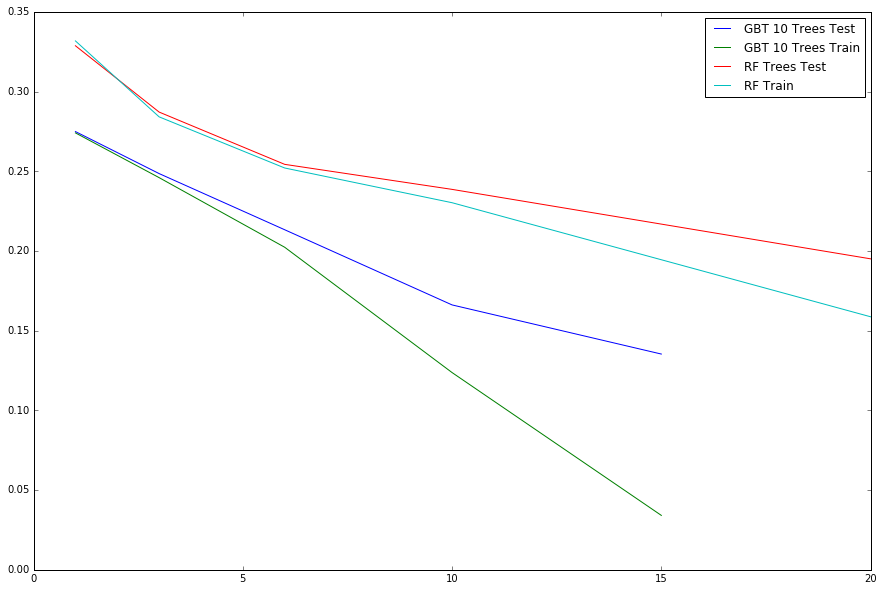

In [11]:
  # Plotting together 
    
%pylab inline
figure(figsize=(15,10))
plot(B10_keys,B10_test,label='GBT 10 Trees Test')
plot(B10_keys,B10_train,label='GBT 10 Trees Train')
plot(RF10_keys,RF10_test,label='RF Trees Test')
plot(RF10_keys,RF10_train,label='RF Train')

pylab.legend()